# TS Clustering By Voyage
### Author William Gilmore

In [14]:
#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import date
import warnings 
import glob

#SciKit
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


#Warnings
warnings.simplefilter('ignore') 

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr


## Access and Filter Data

In [15]:
westcoast = ["../saildrone_data/saildrone_west_coast_survey_2018_sd1024_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2018_sd1025_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2018_sd1026_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2018_sd1027_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2018_sd1028_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1038_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1039_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1040_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1043_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1044_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1045_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1046_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",
             "../saildrone_data/saildrone_west_coast_survey_2019_sd1047_JPLv5.0_8dy_20210613norep_20210613_20211116.nc",]



ds = xr.open_dataset(westcoast[7])
ds.close()

## Kmeans

In [16]:
#Discards all data with salinity less then or equal to 30
#30
ds['SAL_CTD_MEAN']=ds.SAL_CTD_MEAN.where(ds.SAL_CTD_MEAN>=30, np.nan)

#Converts dataset to dataframe only containing tempreature salinity values and location
# We need the location to later plot the clusters onto a map, ignore for now
df = ds[['TEMP_CTD_MEAN', 'SAL_CTD_MEAN', 'lat', 'lon']].to_dataframe()

#Removes all rows with NaN in one of the columns
df = df.dropna()

#Removes unwanted column
df = df.drop('ob', axis = 1)

#Removes location data
df_no_location = df.drop(['lat', 'lon'], axis = 1)

#Returns contents of dataframe as a list which can be input to pipeline
Km_input = df_no_location.values

In [17]:
scaler =  MinMaxScaler()
scaled_features = scaler.fit_transform(Km_input)

In [23]:
# create kmeans object
kmeans = KMeans(init="random",
                n_clusters=3, #Use the amount of clusters suggested by analysis ananlysis below.
                n_init=10,
                max_iter=300,
                random_state=42)

# fit kmeans object to data
kmeans.fit(scaled_features)

#assigns each point to a cluster 
labels = kmeans.labels_

#Adds groups labels back to the original dataframe
df['labels'] = labels

In [24]:
#Reverse Scaling
#Changes the centroids from being scaled to being the real (temp, sal) data

inverted_scaled_centroids = scaler.inverse_transform(kmeans.cluster_centers_)

## Cluster Analysis

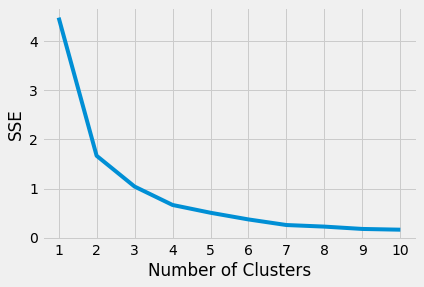

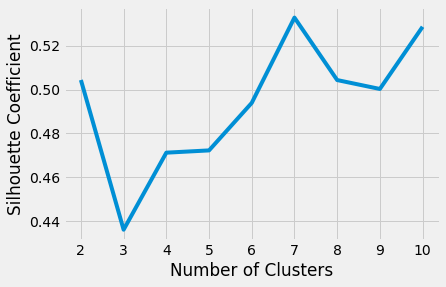

In [25]:
#Elbow Method
#Kmeans object
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()



#Silhouette Coefficient
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Clusters

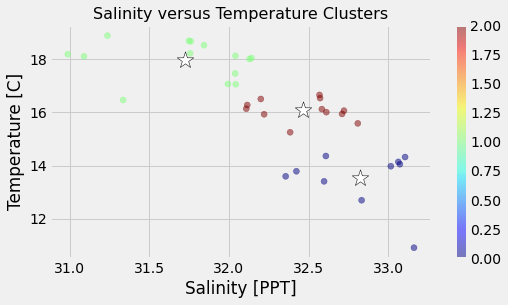

In [26]:


fig = plt.figure(figsize=(7.6,4)) 

#plots data points
sc = plt.scatter(x = Km_input[:, 1], y = Km_input[:, 0], c = labels, cmap='jet', alpha = 0.5)
clb = fig.colorbar(sc)

#plots Centroids
plt.scatter(
    inverted_scaled_centroids[:, 1], inverted_scaled_centroids[:, 0],
   s=300, marker='*',
    c='white', edgecolor='black',
    label='centroids'
)

#window dressing
plt.title('Salinity versus Temperature Clusters', fontdict = {'fontsize' : 16})
plt.xlabel("Salinity [PPT]")
plt.ylabel("Temperature [C]")
#plt.grid()



plt.show()

## TS Clusters on Map

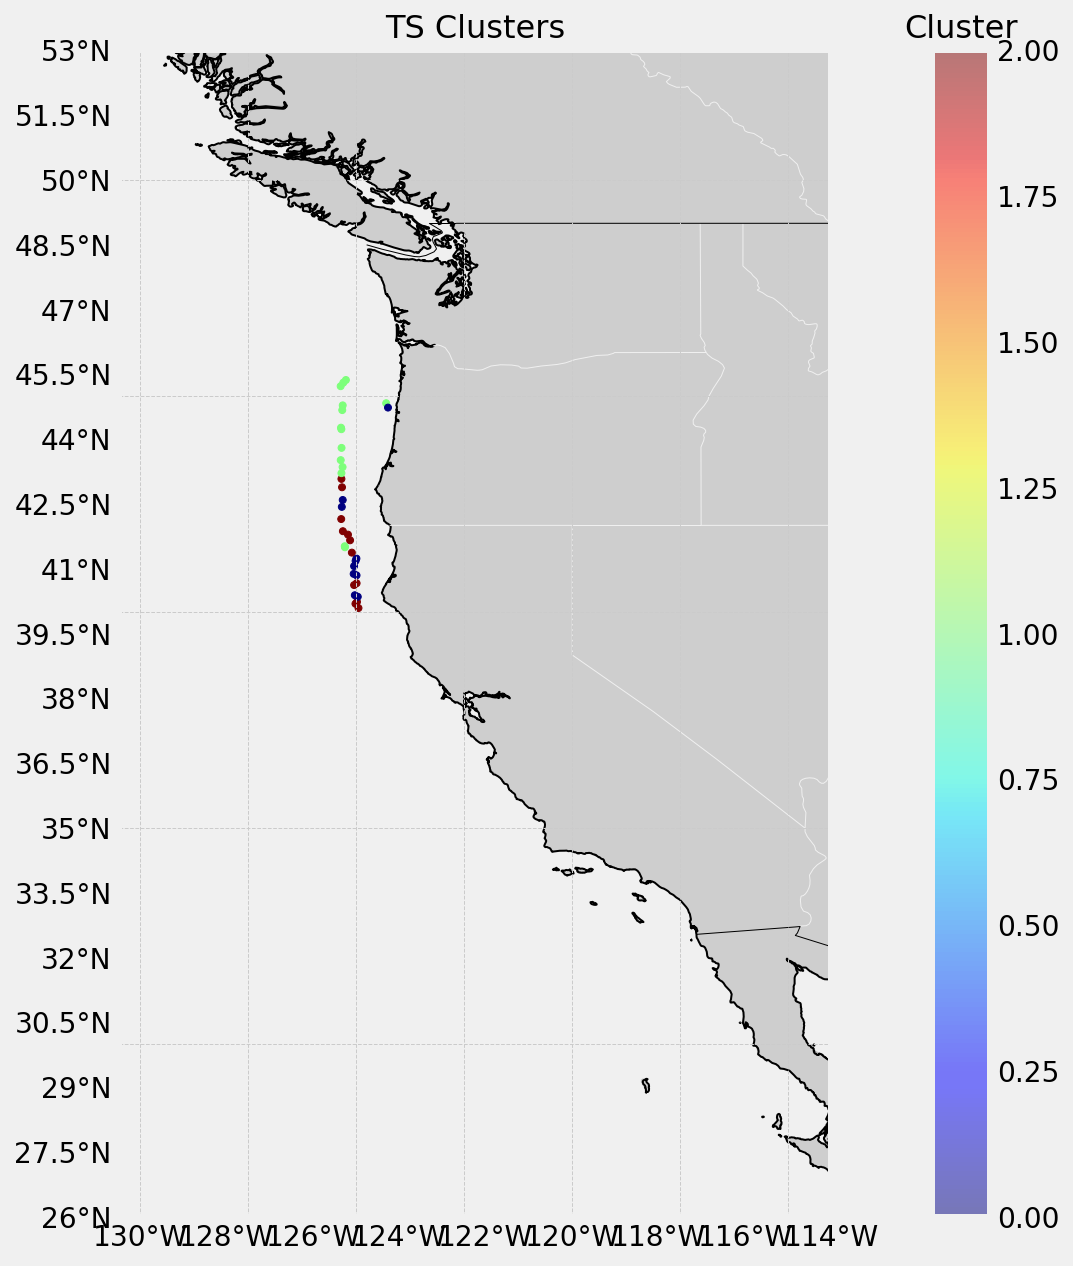

In [27]:
#define latitude and longitude boundaries
latr = [27, 52] 
lonr = [-115, -130] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 144) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

clb = fig.colorbar(sc)
clb.ax.set_title('Cluster', fontdict = {'fontsize' : 16})
                 
# Plot track data, color by temperature
loc = mdates.AutoDateLocator()
sc = plt.scatter(x = df['lon'], y = df['lat'], s = 12, c = df['labels'], cmap='jet')
#plt.plot(ds['lon'], ds['lat'], ls = ':', c = 'navy', alpha = 0.4)
#clb = fig.colorbar(sc, ticks=np.linspace(min(ds['date']), max(ds['date']), 11))

#clb.set_ticklabels(ds['time'].dt.date[default_x_ticks].values)
plt.title('TS Clusters', fontdict = {'fontsize' : 16})
plt.show()